In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
max_degree = 20 # 多项式的最⼤阶数
n_train, n_test = 100, 100 # 训练和测试数据集⼤⼩
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1)) #x分别次方
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) #加入ϵ

In [8]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [11]:
# 从⽣成的数据集中查看⼀下前2个样本
features[:2], poly_features[:2, :], labels[:2];

In [12]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [13]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
            num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                                batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                    evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0144153  1.1910193 -3.4158072  5.614367 ]]


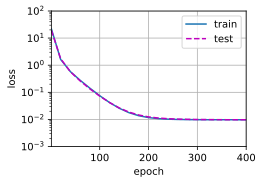

In [14]:
# 测试-打印权重
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
labels[:n_train], labels[n_train:])

weight: [[2.947303  3.7296093]]


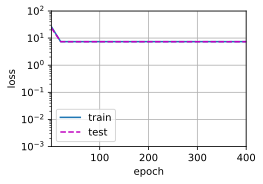

In [15]:
# 线性函数拟合(⽋拟合)
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
labels[:n_train], labels[n_train:])

weight: [[ 4.9914560e+00  1.2606567e+00 -3.3058782e+00  5.2196703e+00
  -3.3535582e-01  1.2828554e+00  4.5469441e-02  2.1042533e-01
   2.2008437e-01  1.6203484e-01  2.1638721e-01  1.9405662e-01
  -1.2557675e-01 -8.8832878e-02  4.9811169e-03 -9.8527916e-02
   1.1529206e-01  8.7835729e-02  5.5951008e-04  2.1326756e-01]]


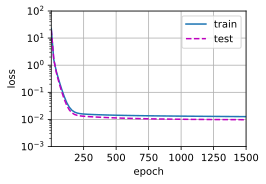

In [16]:
# ⾼阶多项式函数拟合(过拟合)
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:], num_epochs=1500)

⼩结    
• ⽋拟合是指模型⽆法继续减少训练误差。过拟合是指训练误差远小于验证误差。    
• 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不⼀定意味着泛化误差的减小。机器学习模型需要注意防⽌过拟合，即防⽌泛化误差过⼤。     
• 验证集可以⽤于模型选择，但不能过于随意地使⽤它。    
• 我们应该选择⼀个复杂度适当的模型，避免使⽤数量不⾜的训练样本。

练习   
1. 你能准确地解出这个多项式回归问题吗？提⽰：使⽤线性代数。
2. 考虑多项式的模型选择：
    1. 绘制训练损失与模型复杂度（多项式的阶数）的关系图。你观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
    2. 在这种情况下绘制测试的损失图。
    3. ⽣成同样的图，作为数据量的函数。
3. 如果你不对多项式特征xi进⾏标准化(1/i!)，会发⽣什么事情？你能⽤其他⽅法解决这个问题吗？
4. 你能期待看到泛化误差为零吗？

In [ ]:
# 1.
# 以20为最高幂直接给出一个不确切的解析解
w_=torch.linalg.inv(poly_features.t()@poly_features)@poly_features.t()@labels.reshape(200,1)
# 以3为最高幂直接给出解析解
w_=torch.linalg.inv(poly_features[:,:4].t()@poly_features[:,:4])@poly_features[:,:4].t()@labels.reshape(200,1)

1. $$
\begin{aligned}
&\text { 令 } \hat{Y}=X W \text {, 其中 } X=\left(1, x, \frac{x^{2}}{2 !}, \frac{x^{2}}{3 !}\right)\\
&W \text { 解析解使得 Loss }=\|Y-\hat{Y}\|_{2} \text { 最小 }\\
&\text { Loss }=(Y-X W)^{T}(Y-X W)\\
&=Y^{T} Y-W^{T} X^{T} Y-Y^{T} X W+W^{T} X^{T} X W\\
&=Y^{T} Y-2 Y^{T} X W+W^{T} X^{T} X W\\
&\text { 则 } \frac{\delta L}{\delta W}=-2 X^{T} Y+2 X^{T} X W\\
&\text { 令 } \frac{\delta L}{\delta W}=0 \text {, 得 } W=\left(X^{T} X\right)^{-1} X^{T} Y\\
&\text { 则 } y=w_{1} * 1+w_{2} * x+w_{3} * \frac{x^{2}}{2 !}+w_{4} * \frac{x^{2}}{3 !}
\end{aligned}
$$

In [ ]:
# 2.略
# 至少4阶多项式
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6,...,])

3.    
在优化的过程中，我们通常希望避免⾮常⼤的梯度值或损失值。这就是我们将特征从xi调整为xi/i! 的原因，这样可以避免很⼤的i带来的特别⼤的指数值。  
也可设梯度或瞬死阈值

4. 理论上不可能，因为数据带有一定的噪声，不可能完全的拟合。